<a href="https://colab.research.google.com/github/FlaviodosSantos/Prevendo_os_pre-os_das_a-es_com_Python/blob/main/Prevendo_os_pre%C3%A7os_das_a%C3%A7%C3%B5es_com_Python_usando_Regress%C3%A3o_Linear_e_Rede_Neural_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Prevendo preço de ações</h1>
Trabalho para 3º Unidade de SAD - UFRN - 2022.1

Flavio Roberto O. dos Santos

Importando as bibliotecas


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor # rede neural Multi-layer Perceptron
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

Lendo o arquivo PETR4.SA (2018-2020)

In [2]:
df = pd.read_csv('PETR4.SA.csv')
df # 5 primeiras e 5 ultimas

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,10.236185,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,10.328962,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,10.347516,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,10.409367,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,10.533066,28400000
...,...,...,...,...,...,...,...
737,2020-12-22,27.200001,27.469999,27.049999,27.280001,18.187618,46513200
738,2020-12-23,27.430000,28.250000,27.350000,27.950001,18.634308,49038900
739,2020-12-28,28.360001,28.520000,28.180000,28.180000,18.787649,36313300
740,2020-12-29,28.379999,28.430000,27.990000,28.270000,18.847652,29891100


Verificando os tipos das colunas

In [3]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

Criando novos campos de medias móveis

In [4]:
df['mm7'] = df['Adj Close'].rolling(7).mean() # media de 7 dias
df['mm21d'] = df['Adj Close'].rolling(21).mean() # media de 21 dias

Adicioando um dia a frente 

In [5]:
df['Adj Close'] = df['Adj Close'].shift(-1)
df.head() # exibe as 5 primeiras linhas

,Date,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,10.328962,33461800,NaN,NaN
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,10.347516,55940900,NaN,NaN
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,10.409367,37064900,NaN,NaN
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,10.533066,26958200,NaN,NaN
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,10.533066,28400000,NaN,NaN


Apagando os dados nulos (NaN)

In [6]:
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d
20,2018-01-30,19.770000,19.770000,19.360001,19.490000,12.184464,46203000,11.898186,11.095313
21,2018-01-31,19.740000,19.930000,19.680000,19.700001,12.691636,41576600,12.006866,11.188088
22,2018-02-01,19.760000,20.620001,19.760000,20.520000,12.351459,51950200,12.208321,11.300596
23,2018-02-02,20.299999,20.420000,19.850000,19.969999,11.776254,50657800,12.263985,11.396022
24,2018-02-05,19.650000,19.969999,19.040001,19.040001,12.363830,62268600,12.237478,11.461112
...,...,...,...,...,...,...,...,...,...
736,2020-12-21,27.190001,27.490000,26.520000,27.020000,18.187618,99988800,18.533350,17.857442
737,2020-12-22,27.200001,27.469999,27.049999,27.280001,18.634308,46513200,18.505730,17.926652
738,2020-12-23,27.430000,28.250000,27.350000,27.950001,18.787649,49038900,18.537160,17.981575
739,2020-12-28,28.360001,28.520000,28.180000,28.180000,18.847652,36313300,18.568590,18.042848


Verificando a quantidade de linhas

In [7]:
qtd_linhas = len(df)

qtd_linhas_treino= round(.50 * qtd_linhas)
qtd_linhas_teste= 300 
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:360 linhas teste= 360:659 linhas validação= 720'

Resetando o index 

In [8]:
df = df.reset_index(drop=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,mm7,mm21d
0,2018-01-30,19.770000,19.770000,19.360001,19.490000,12.184464,46203000,11.898186,11.095313
1,2018-01-31,19.740000,19.930000,19.680000,19.700001,12.691636,41576600,12.006866,11.188088
2,2018-02-01,19.760000,20.620001,19.760000,20.520000,12.351459,51950200,12.208321,11.300596
3,2018-02-02,20.299999,20.420000,19.850000,19.969999,11.776254,50657800,12.263985,11.396022
4,2018-02-05,19.650000,19.969999,19.040001,19.040001,12.363830,62268600,12.237478,11.461112
...,...,...,...,...,...,...,...,...,...
716,2020-12-21,27.190001,27.490000,26.520000,27.020000,18.187618,99988800,18.533350,17.857442
717,2020-12-22,27.200001,27.469999,27.049999,27.280001,18.634308,46513200,18.505730,17.926652
718,2020-12-23,27.430000,28.250000,27.350000,27.950001,18.787649,49038900,18.537160,17.981575
719,2020-12-28,28.360001,28.520000,28.180000,28.180000,18.847652,36313300,18.568590,18.042848


In [9]:
df_completo = df

In [10]:
#separando as features e labels
features = df.drop(['Close', 'Adj Close','Date'], 1)
labels = df['Adj Close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [11]:
#Agora vamos escolher as melhores variaveis para da nossa base de dados com Kbest

features_list = ('Open','High','Low','Volume','mm7','mm21d')

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ('')
print ("Melhores features:")
print (k_best_features_final)


Melhores features:
{'Low': 77.35838563433258, 'Volume': 64.67234075538278, 'High': 59.80413192078181, 'mm21d': 51.73814738574214, 'mm7': 2.6203080422026455}


Separando as features escolhidas

In [12]:
features = df.loc[:,['High','Low','Volume','mm7']]
features

,High,Low,Volume,mm7
0,19.770000,19.360001,46203000,11.898186
1,19.930000,19.680000,41576600,12.006866
2,20.620001,19.760000,51950200,12.208321
3,20.420000,19.850000,50657800,12.263985
4,19.969999,19.040001,62268600,12.237478
...,...,...,...,...
716,27.490000,26.520000,99988800,18.533350
717,27.469999,27.049999,46513200,18.505730
718,28.250000,27.350000,49038900,18.537160
719,28.520000,28.180000,36313300,18.568590


Separando os dados de treino teste e validação

In [13]:

X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

360 360
299 299


Normalizando os dados de entrada(features)



In [14]:
# Gerando o novo padrão
scaler = MinMaxScaler()
X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)
X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

In [15]:
#treinamento usando regressão linear
lr = linear_model.LinearRegression()
lr.fit(X_train_scale, y_train)
pred1= lr.predict(X_test_scale)
cd1 =r2_score(y_test, pred1)

f'Coeficiente de determinação:{cd1 * 100:.2f}'

'Coeficiente de determinação:94.15'

In [16]:
#rede neural
rn = MLPRegressor(max_iter=2000)

rn.fit(X_train_scale, y_train)
pred2= rn.predict(X_test_scale)

cd2 = rn.score(X_test_scale, y_test)


f'Coeficiente de determinação:{cd2 * 100:.2f}'

'Coeficiente de determinação:94.72'

In [17]:
#rede neural com ajuste hyper parameters

rn_hp = MLPRegressor()

parameter_space = {
        'hidden_layer_sizes': [(i,) for i in list(range(1, 21))],
        'activation': ['tanh', 'relu'],
        'solver': ['sgd', 'adam', 'lbfgs'], 
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
    }

search = GridSearchCV(rn_hp, parameter_space, n_jobs=-1, cv=5)


search.fit(X_train_scale,y_train)
clf = search.best_estimator_
pred3= search.predict(X_test_scale)

cd3 = search.score(X_test_scale, y_test)

f'Coeficiente de determinação:{cd3 * 100:.2f}'

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


'Coeficiente de determinação:95.09'

In [18]:
valor_novo = features.tail(50)
valor_novo.head()

,High,Low,Volume,mm7
671,19.770000,19.440001,56952100,13.315935
672,19.709999,19.320000,49929000,13.258789
673,19.940001,19.250000,107419300,13.233073
674,20.270000,19.590000,68407700,13.208310
675,20.330000,19.830000,60594900,13.242598


In [19]:
#executando a previsão da regressão linear

previsao=scaler.transform(valor_novo)
pred4=lr.predict(previsao)
pred4

array([12.48000302, 12.40925836, 12.37539688, 12.57254333, 12.70113695,
       12.85105958, 13.13152771, 12.84395383, 12.73578672, 12.08732325,
       11.61639357, 12.16196833, 12.39400141, 12.36551251, 12.57667858,
       12.48532464, 13.450251  , 13.92125023, 14.30493255, 13.99673005,
       14.10275729, 14.81548341, 14.85059845, 15.1626882 , 15.07285527,
       15.51236044, 16.47661964, 16.55569698, 16.50616022, 16.48928637,
       16.19142714, 16.43624815, 16.52139665, 16.91445095, 17.47890738,
       17.32502843, 17.19544772, 17.18374472, 17.66187352, 17.74389275,
       17.9580569 , 17.9416188 , 17.90591383, 18.23850122, 18.2258957 ,
       17.40633323, 17.66950688, 17.88337668, 18.31485424, 18.2186502 ])

In [20]:
#executando a previsão da rede neural

previsao_rn=scaler.transform(valor_novo)
pred_rn=rn.predict(previsao_rn)
pred_rn

array([12.52911692, 12.46643931, 12.50133108, 12.65482207, 12.7397491 ,
       12.9382881 , 13.14728856, 12.88655232, 12.80557247, 12.27569245,
       11.9940654 , 12.29152213, 12.46272378, 12.46321337, 12.54790224,
       12.48741374, 13.60460235, 14.01276786, 14.31444873, 14.08521659,
       14.18897355, 14.79758103, 14.98161327, 15.17739825, 15.10629296,
       15.6133113 , 16.51011792, 16.56899717, 16.47809993, 16.52456986,
       16.36437075, 16.50117594, 16.70442833, 16.99079524, 17.44429314,
       17.42697203, 17.25072015, 17.25141502, 17.78897179, 17.78482906,
       17.99930705, 17.94255664, 17.99478406, 18.22550498, 18.22814724,
       17.63015048, 17.75089983, 18.01823379, 18.30324882, 18.23367315])

In [21]:
#executando a previsão da rede neural com ajuste hyper parameters

previsao_rn2=scaler.transform(valor_novo)
pred_rn2=search.predict(previsao_rn2)
pred_rn2

array([12.63792235, 12.54872839, 12.77107695, 12.7511249 , 12.80565324,
       13.11055373, 13.16415357, 12.94855211, 12.85537567, 12.5055331 ,
       12.25372109, 12.43250053, 12.56510729, 12.5408909 , 12.53483057,
       12.46473209, 13.85561101, 14.26390718, 14.33410432, 14.12154639,
       14.22039516, 14.92611432, 15.0921348 , 15.21448156, 15.15703969,
       15.81612866, 16.73204432, 16.57208359, 16.45287085, 16.53896194,
       16.53733667, 16.60163645, 16.85629182, 17.03676444, 17.45077773,
       17.46945416, 17.27255734, 17.32863478, 17.94279027, 17.83264488,
       18.04253297, 17.99035878, 18.07846694, 18.25335312, 18.29157045,
       17.9203826 , 17.87028959, 18.09512463, 18.32174054, 18.24216518])

In [22]:
data_pregao_full=df_completo['Date']
data_pregao=data_pregao_full.tail(50)

res_full=df_completo['Adj Close']
res=res_full.tail(50)

df2=pd.DataFrame({'Date':data_pregao, 'real':res, 'regressão linear':pred4, 'rede neural':pred_rn, 'rede neural HP':pred_rn2})


df2.set_index('Date', inplace=True)

#print(df2)
df2.head()

,real,regressão linear,rede neural,rede neural HP
Date,,,,
2020-10-15,12.887341,12.480003,12.529117,12.637922
2020-10-16,13.014015,12.409258,12.466439,12.548728
2020-10-19,13.454038,12.375397,12.501331,12.771077
2020-10-20,13.440703,12.572543,12.654822,12.751125
2020-10-21,13.894059,12.701137,12.739749,12.805653


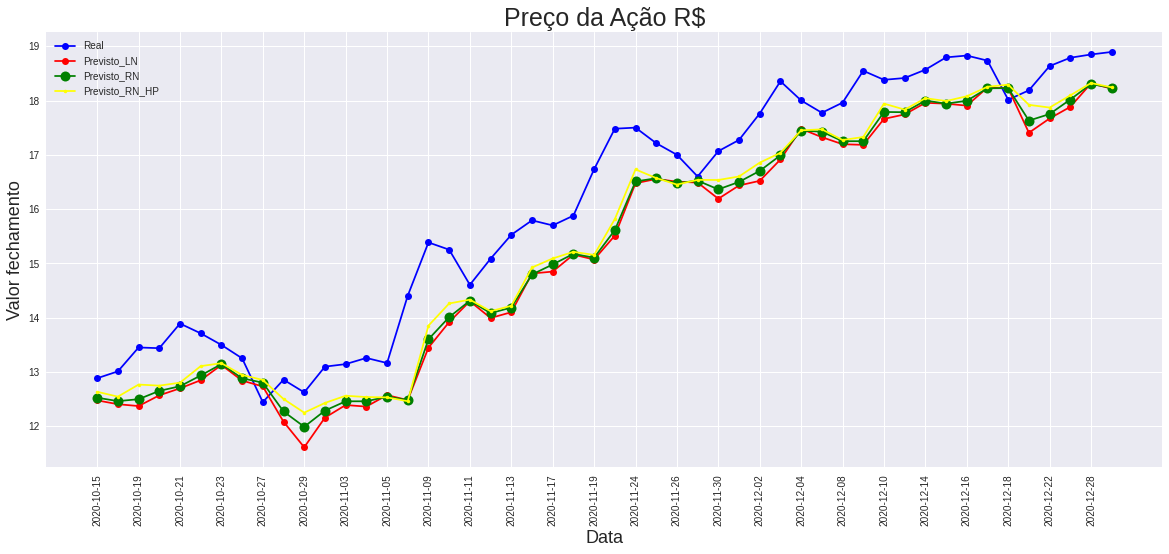

In [23]:
plt.style.use('seaborn')
plt.figure(figsize=(20,8))
plt.title("Preço da Ação R$",fontsize=25)
plt.plot(df2["real"],label = "Real", color = "blue", marker = 'o')
plt.plot(df2["regressão linear"],label = "Previsto_LN", color = "red", marker = 'o')
plt.plot(df2["rede neural"],label = "Previsto_RN", color = "green", marker = 'o', markersize=10)
plt.plot(df2["rede neural HP"],label = "Previsto_RN_HP", color = "yellow", marker = '.')
plt.xticks(range(0,df2.shape[0],2),rotation=90)
plt.xlabel("Data",fontsize=18)
plt.ylabel("Valor fechamento",fontsize=18)
plt.legend()
